# Deducing the concentration of PM2.5 based on AOD and weather, etc. with Machine Learning Models

> Note: This notebook is under development. <br> Author: Weiye Chen (weiyechen@zju.edu.cn)
<br> Collaborating with Keran Sun, Qingjie Yang, Anzhou Li.

## 0. Importing Libraries

In [1]:
from osgeo import gdal

In [2]:
from scipy import stats

In [3]:
import sklearn

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [5]:
import math
import scipy as sp
from scipy.stats import randint as sp_randint

In [6]:
import csv

In [7]:
# Render matplotlib graph as SVG
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [8]:
import warnings; warnings.simplefilter('ignore')

## 1. Importing Data
### 1.1 Raster Image I/O

In [9]:
class Grid(object):
    @staticmethod
    def read_img(_file):
        dataset = gdal.Open(_file)
        # 数据描述
        # print(dataset.GetDescription())

        # 图像的列数X与行数Y
        img_width = dataset.RasterXSize
        img_height = dataset.RasterYSize

        # 仿射矩阵
        img_geotrans = dataset.GetGeoTransform()

        # 投影
        img_proj = dataset.GetProjection()

        # 将数据写成数组，对应栅格矩阵
        img_data = dataset.ReadAsArray(0, 0, img_width, img_height)

        # 数据格式大小
        # print(img_data.shape)

        del dataset
        return img_data, img_proj, img_geotrans

    @staticmethod
    def write_img(_file, img_data, img_proj, img_geotrans, _format):
        # 判断栅格数据的数据类型
        if 'int8' in img_data.dtype.name:
            datatype = gdal.GDT_Byte
        elif 'int16' in img_data.dtype.name:
            datatype = gdal.GDT_UInt16
        else:
            datatype = gdal.GDT_Float32

        # 判读数组维数
        if len(img_data.shape) == 3:
            img_bands, img_height, img_width = img_data.shape
        else:
            img_bands, (img_height, img_width) = 1, img_data.shape

        # 创建文件
        # HFA -> .img | GTiff -> .tif
        if _format == 'tif':
            driver = gdal.GetDriverByName("GTiff")
        else:
            driver = gdal.GetDriverByName("HFA")

        dataset = driver.Create(_file, img_width, img_height, img_bands, datatype)

        # 写入仿射变换参数
        dataset.SetGeoTransform(img_geotrans)
        # 写入投影
        dataset.SetProjection(img_proj)
        # 写入数组数据
        # GetRasterBand()
        if img_bands == 1:
            dataset.GetRasterBand(1).WriteArray(img_data)
        else:
            for i in range(img_bands):
                dataset.GetRasterBand(i + 1).WriteArray(img_data[i])

        del dataset

Specifying the extent

In [10]:
x_min = -1225790
x_max = 53952
y_min = -639572
y_max = 685124

In [11]:
from scipy.stats.stats import pearsonr

### 1.2 Loading Samples

In [12]:
def ComputePearsonR():
    fileList = ['14-1', '14-4', '14-7', '15-1', '15-7', '16-1', '16-4', '16-7']
    for file in fileList:
        with open('./table/data-'+ file + '.csv', newline='') as csvfile:
            x_aod = []
            x_at = []
            x_dem = []
            x_rh = []
            x_pr = []
            y = []
            table = csv.DictReader(csvfile, delimiter=',', quotechar='|')
            for row in table:
                x_aod.append(float(row['AOD']))
                x_at.append(float(row['AirTemp']))
                x_dem.append(float(row['DEM']))
                x_rh.append(float(row['RH']))
                x_pr.append(float(row['SeaLevelPr']))
                y.append(float(row['pm2_5']))
            r1 = pearsonr(x_aod, y)
            r2 = pearsonr(x_at, y)
            r3 = pearsonr(x_dem, y)
            r4 = pearsonr(x_rh, y)
            r5 = pearsonr(x_pr, y)
            print(file, r1[1] < 0.05, r2[1] < 0.05, r3[1] < 0.05, r4[1] < 0.05, r5[1] < 0.05)

ComputePearsonR()

14-1 True True True False False
14-4 False True True True True
14-7 True True True True True
15-1 False True True True False
15-7 True True True True True
16-1 True True True False True
16-4 True True True True False
16-7 True True True True True


In [13]:
def loadSample(date, hour):       
    with open('./table/data-'+ str(date) + "-" + str(hour) + '.csv', newline='') as csvfile:
        x_aod = []
        x_at = []
        x_dem = []
        x_rh = []
        x_pr = []
        x_ndvi = []
        x_ws = []
        y = []
        ones = []
        table = csv.DictReader(csvfile, delimiter=',', quotechar='|')
        for row in table:
            ones.append(1.0)
            x_aod.append(float(row['AOD']))
            x_at.append(float(row['AirTemp']))
            x_dem.append(float(row['DEM']))
            x_rh.append(float(row['RH']))
            x_pr.append(float(row['SeaLevelPr']))
            x_ndvi.append(float(row['NDVI']))
            x_ws.append(float(row['WindSpeed']))
            y.append(float(row['pm2_5']))
        xt = [np.array(ones),
              x_ndvi, 
              x_dem, 
              x_aod, 
              x_at, 
              x_rh, 
              x_pr, 
              x_ws]
        xt_np = np.mat(xt)
        x = np.transpose(xt_np)
        y_np = np.transpose(np.mat(y))
#         print(np.shape(x))
#         print(x)
#         print(xt_np)
#         print(y_np)
        return x, xt_np, y_np

### 1.3 Performing Multivariate Linear Regression

In [14]:
class MLR:     
    def __init__(self, x, y = None):
        
        self.init()
        if (y is None):
            self.x = np.array(matrix[:,0:-1])
            self.y = np.array(matrix[:,-1])
            shape = np.shape(matrix)
            self.k = shape[1] - 2
            self.n = shape[0]
        else:
            self.x = x
            self.y = y
            self.k = np.shape(x)[1] - 1
            self.n = np.shape(x)[0]
    
    def init(self):
        self.r2 = 0.
        self.t = []
        self.p_t = []
        self.f = 0.
        self.p_f = 0.
        self.ess = 0.
        self.rss = 0.
        self.tss = 0.
        self.r2_adj = 0.

        
    def OLS(self):
        x = self.x
        y = self.y
        x_t = np.transpose(x)
        xt_x_inv = np.matmul(x_t, x)
        xt_x_inv = np.linalg.inv(xt_x_inv)
        beta = np.matmul(xt_x_inv, x_t)
        beta = np.matmul(beta, y)
        self.beta = beta
        y_e = self.PredictionE(x)
        deviation1 = self.y - y_e
        print(deviation1)
        deviation = deviation1 ** 2
        self.rss = np.sum(deviation)
        mean = np.mean(y)
        self.tss = np.sum((y-mean) * (y-mean))
        self.ess = self.tss - self.rss
        self.f = (self.ess / self.k) / (self.rss / (self.n - self.k - 1))
        self.r2 = 1 - self.rss / self.tss
        self.r2_adj = 1 - (self.rss / (self.n - self.k - 1)) / (self.tss / (self.n - 1))
        self.p_f = 1 - stats.f.cdf(self.f, self.k, (self.n - self.k - 1))
        sigma2 = self.rss / (self.n - self.k - 1)
        beta_array = np.array(np.transpose(beta)[0])
        cii = []
        for i in range(0, self.k + 1):
            cii.append(xt_x_inv[i][i])
        cii_np = np.array(cii)
        self.t = beta_array / np.sqrt(cii_np * sigma2)
        self.p_t = 1 - stats.t.cdf(np.absolute(self.t), self.n - self.k - 1)
        
    def PredictionE(self, x):
        return np.matmul(x, self.beta)

### 1.4 Import Image Data

In [15]:
img_templete, proj_templete, geotrans_templete = Grid.read_img("./img_data/dem.tif")
line_num, row_num = img_templete.shape

In [16]:
img_intercept = img_templete.copy()
img_aod = img_templete.copy()
img_t = img_templete.copy()
img_p = img_templete.copy()
img_ws = img_templete.copy()
img_rh = img_templete.copy()
img_dem = img_templete.copy()
img_ndvi = img_templete.copy()

In [17]:
DEM = img_templete
NDVI, proj, trans = Grid.read_img("./img_data/ndvi.tif")
imageDictTemplate = {
    'Intercept': img_intercept,
    'AOD': img_aod,
    'T': img_t,
    'P': img_p,
    'WS': img_ws,
    'RH': img_rh
}

In [18]:
def readImageDataAsArray(filePath):
    data = Grid.read_img(filePath)[0]
    shape = np.shape(data)
    array = data.ravel()
#     print("Original Shape: \t" + str(shape))
#     print("Flattened array size: \t" + str(np.shape(array)[0]))
#     print("Array:\t" + str(array))
    return array, shape

In [19]:
ndviArray, shape = readImageDataAsArray("./img_data/ndvi.tif")
demArray = readImageDataAsArray("./img_data/dem.tif")[0]

In [20]:
def dict2Mat(date, hour):
    matrix = np.mat([
        ndviArray.astype("float32").ravel(), 
        demArray.astype("float32").ravel(), 
        readImageDataAsArray("./img_data/aod-" + str(date) + "-" + str(hour) + ".tif")[0],
        readImageDataAsArray("./img_data/t-" + str(date) + "-" + str(hour) + ".tif")[0],
        readImageDataAsArray("./img_data/rh-" + str(date) + "-" + str(hour) + ".tif")[0],
        readImageDataAsArray("./img_data/p-" + str(date) + "-" + str(hour) + ".tif")[0],
        readImageDataAsArray("./img_data/ws-" + str(date) + "-" + str(hour) + ".tif")[0]
    ])
    return matrix

## 2. Regression Using Machine Learning

### 2.1 Preprocessing the sample data

Divide sample data into two sets with randomness, one for training and one for testing.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

Before we move on to the machine learning model, we should normalize the data. It's very important as to improve the performance of the machine learning models.

In [22]:
def getStdSample(sample):
    std = np.array(np.std(sample, axis = 0))[0]
#     print("Standard deviation:")
#     print(std)
    return std

In [23]:
def getMeanSample(sample):
    mean = np.array(np.mean(sample, axis = 0))[0]
#     print("Mean:")
#     print(mean)
    return mean

In [24]:
def normalize(sample):
    matrix = preprocessing.scale(sample)
#     print("Normalized Sample Matrix")
#     print(matrix)
    return matrix, getMeanSample(sample), getStdSample(sample)

In [25]:
def DivideData(matrix, ratioTesting):
    x = np.array(matrix[:,0:-1])
    y = np.array(np.transpose(matrix[:,-1]))
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=ratioTesting)
    return xtrain, xtest, ytrain, ytest

### 2.2 Preprocessing image data

In [26]:
def normalizeImg(matrix, mean, std):
    matrix = np.transpose(matrix)
    meanMat = np.ones(np.shape(matrix))
    stdMat = np.ones(np.shape(matrix))
    meanMat = meanMat * mean
    stdMat = stdMat * std
    matrix = (matrix - meanMat) / stdMat
    return matrix

### 2.3 Regression and Cross Validation

#### 2.3.1 Load Cross Validation Library
Parameters should be tuned before applied to prediction processes. [Sci-Kit Learn Doc](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)

Grid Search CV: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

Printing function of the Cross Validation results

In [28]:
def printBestParameterInfo(regr, modelName=None):
    print("------ " + modelName + " ------")
    print("Best parameters set found on development set:")
    print()
    print(regr.best_params_)
    print()
#     print("Grid scores on development set:")
#     print()
#     means = regr.cv_results_['mean_test_score']
#     stds = regr.cv_results_['std_test_score']
#     for mean, std, params in zip(means, stds, regr.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r"
#               % (mean, std * 2, params))
    print()

#### 2.3.2 Supporting Vector Machine Regression
API Doc: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
<br>Doc on SVM: https://scikit-learn.org/stable/modules/svm.html#svm-regression

In [29]:
from sklearn.svm import SVR

In [30]:
def SVMR(xtrain, ytrain):
    param_dist = {
        "kernel": ['rbf', 'poly', 'sigmoid'],
        "C": [1, 10, 100, 1000],
        "gamma": [0.001, 0.0001],
        "epsilon": [0.1, 0.3, 0.5]
    }
    regr = GridSearchCV(SVR(), param_dist, cv=5)
#     regr = SVR(gamma='scale', C=1.0, epsilon=0.2)
    regr.fit(xtrain, ytrain)
    printBestParameterInfo(regr, "SVR")
    return regr

#### 2.3.3 Multilayer Perceptron
API Doc: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

In [31]:
from sklearn.neural_network import MLPRegressor

In [32]:
def multiLayerPerceptron(xtrain, ytrain):
    param_dist = [{
        "solver": ['lbfgs'],
        "activation": ['identity', 'logistic', 'tanh', 'relu'],
        "alpha": [0.001, 0.0001]
    },{
        "solver": ['adam'],
        "activation": ['identity', 'logistic', 'tanh', 'relu'],
        "alpha": [0.001, 0.0001],
        "learning_rate_init": [0.001, 0.01]
    },{
        "solver": ['sgd'],
        "activation": ['identity', 'logistic', 'tanh', 'relu'],
        "alpha": [0.001, 0.0001],
        "learning_rate": ['constant', 'invscaling', 'adaptive'],
        "learning_rate_init": [0.001, 0.01],
        "momentum": [0.7, 0.8, 0.9]
    }]
    regr = GridSearchCV(MLPRegressor(), param_dist, cv=5)
#     regr = MLPRegressor(solver='lbfgs', activation = 'logistic', alpha=1e-6, hidden_layer_sizes=(5, 5), random_state=1)
    regr.fit(xtrain, ytrain)
    printBestParameterInfo(regr, "MLP")
    return regr

#### 2.3.4 Random Forest Regressor
API Doc: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor

In [33]:
from sklearn.ensemble import RandomForestRegressor

In [34]:
def randomForest(xtrain, ytrain):
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 2)]
    # Number of features to consider at every split
#     max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 3]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    param_dist = {'n_estimators': n_estimators,
#                    'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    regr = GridSearchCV(RandomForestRegressor(), param_dist, cv=5)
#     regr = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)
    regr.fit(xtrain, ytrain)
    printBestParameterInfo(regr, "Random Forests")
    
    return regr

### 2.4 Prediction

In [35]:
def denormalizeImg(matrix, mean, std):
    matrix = matrix * std + mean
    return matrix

## 3. Put things altogether

### 3.1 Serialized Deduction Procedure

1. Load samples
2. Normalize samples and divide data into sets randomly
3. Train the ML models with cross-validation
4. Load Image data and normalize them using the scale in samples
5. Predict PM2.5 concentration and save the map
6. Display and export ML regression model thumbnails

In [36]:
def PM25ConcentrationDeduction(date, hour):
    print("Running PM 2.5 Deduction Program on " + str(date) + "-" + str(hour) + " (date-hour).")
    #### Getting Samples Ready ####
    # import sample table
    x, xt, y = loadSample(date, hour)
    # normalize sample
    norm = normalize(np.column_stack((x, y))[:, 1:]) # returns normalized sample table, mean, standard deviation
    # partition samples
    xtr, xte, ytr, yte = DivideData(norm[0], 0.2)
    
    #### Train Models using Samples ####
    svm = SVMR(xtr, ytr)
    print("SVM Model Score: " + str(svm.score(xte, yte)))
    mlp = multiLayerPerceptron(xtr, ytr)
    print("MLP Model Score: " + str(mlp.score(xte, yte)))
    rf = randomForest(xtr, ytr)
    print("Random Forests Model Score: " + str(rf.score(xte, yte)))
    
    #### Predicting on the field data ####
    # read all variables matrix related to this time
    matrix = dict2Mat(date, hour)
    normImg = normalizeImg(matrix, norm[1][0:-1], norm[2][0:-1])
    pred_svm = np.reshape(svm.predict(normImg), shape)
    pred_svm = denormalizeImg(pred_svm, norm[1][-1], norm[2][-1])
    pred_mlp = np.reshape(mlp.predict(normImg), shape)
    pred_mlp = denormalizeImg(pred_mlp, norm[1][-1], norm[2][-1])
    pred_rf = np.reshape(rf.predict(normImg), shape)
    pred_rf = denormalizeImg(pred_rf, norm[1][-1], norm[2][-1])
    Grid.write_img("./svm-" + str(date) + "-" + str(hour) + ".tif", pred_svm, proj_templete, geotrans_templete, "GTiff")
    Grid.write_img("./mlp-" + str(date) + "-" + str(hour) + ".tif", pred_mlp, proj_templete, geotrans_templete, "GTiff")
    Grid.write_img("./rf-" + str(date) + "-" + str(hour) + ".tif", pred_rf, proj_templete, geotrans_templete, "GTiff")
    
    print("Task of Running PM 2.5 Deduction Program on " + str(date) + "-" + str(hour) + " (date-hour) is finished.")

In [37]:
def showDeducedPM25(date, hour):
    print("Here are the deduced PM2.5 concentration maps on Mar. " + str(date) + " " + str(hour) + ":00 based on Machine Learning Models")
    svm = Grid.read_img("./svm-" + str(date) + "-" + str(hour) + ".tif")[0]
    mlp = Grid.read_img("./mlp-" + str(date) + "-" + str(hour) + ".tif")[0]
    rf = Grid.read_img("./rf-" + str(date) + "-" + str(hour) + ".tif")[0]

    a = np.array([0,7, 12, 16, 20, 23, 26, 30.5, 35.5, 55.5,150.5,500])
    norm = matplotlib.colors.BoundaryNorm(a, 256)

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharey=True)
    fig.suptitle("Mar. " + str(date) + " " + str(hour+8) + ":00, 2019: PM2.5 Concentration Deduced using Machine Learning", fontsize=18)
    fig.subplots_adjust(wspace = 0.05)
    # plt.subplot(131)
    ax[0].title.set_text("Supporting Vector Machine")
    im = ax[0].imshow(svm, cmap="RdYlGn_r", norm=norm)
    # plt.subplot(132)
    ax[1].title.set_text("Multilayer Perceptron")
    ax[1].imshow(mlp, cmap="RdYlGn_r", norm=norm)
    # plt.subplot(133)
    ax[2].title.set_text("Random Forest")
    ax[2].imshow(rf, cmap="RdYlGn_r", norm=norm)

    cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.82)
    
    fig.savefig("./ml-" + str(date) + "-" + str(hour) + "_thumb.png", dpi=200)

In [38]:
PM25ConcentrationDeduction(14,1)
PM25ConcentrationDeduction(14,4)
PM25ConcentrationDeduction(14,7)
PM25ConcentrationDeduction(15,1)
PM25ConcentrationDeduction(15,4)
PM25ConcentrationDeduction(15,7)
PM25ConcentrationDeduction(16,1)
PM25ConcentrationDeduction(16,4)
PM25ConcentrationDeduction(16,7)

Running PM 2.5 Deduction Program on 14-1 (date-hour).
------ SVR ------
Best parameters set found on development set:

{'C': 1000, 'epsilon': 0.5, 'gamma': 0.001, 'kernel': 'rbf'}


SVM Model Score: 0.6149988674933399
------ MLP ------
Best parameters set found on development set:

{'activation': 'relu', 'alpha': 0.001, 'learning_rate_init': 0.01, 'solver': 'adam'}


MLP Model Score: 0.685999462486507
------ Random Forests ------
Best parameters set found on development set:

{'bootstrap': True, 'max_depth': 60, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


Random Forests Model Score: 0.5579641405603615
Task of Running PM 2.5 Deduction Program on 14-1 (date-hour) is finished.
Running PM 2.5 Deduction Program on 14-4 (date-hour).
------ SVR ------
Best parameters set found on development set:

{'C': 1000, 'epsilon': 0.3, 'gamma': 0.001, 'kernel': 'rbf'}


SVM Model Score: 0.4022660564903455
------ MLP ------
Best parameters set found on development set:

{'activa

Here are the deduced PM2.5 concentration maps on Mar. 14 1:00 based on Machine Learning Models
Here are the deduced PM2.5 concentration maps on Mar. 14 4:00 based on Machine Learning Models
Here are the deduced PM2.5 concentration maps on Mar. 14 7:00 based on Machine Learning Models
Here are the deduced PM2.5 concentration maps on Mar. 15 1:00 based on Machine Learning Models
Here are the deduced PM2.5 concentration maps on Mar. 15 4:00 based on Machine Learning Models
Here are the deduced PM2.5 concentration maps on Mar. 15 7:00 based on Machine Learning Models
Here are the deduced PM2.5 concentration maps on Mar. 16 1:00 based on Machine Learning Models
Here are the deduced PM2.5 concentration maps on Mar. 16 4:00 based on Machine Learning Models
Here are the deduced PM2.5 concentration maps on Mar. 16 7:00 based on Machine Learning Models


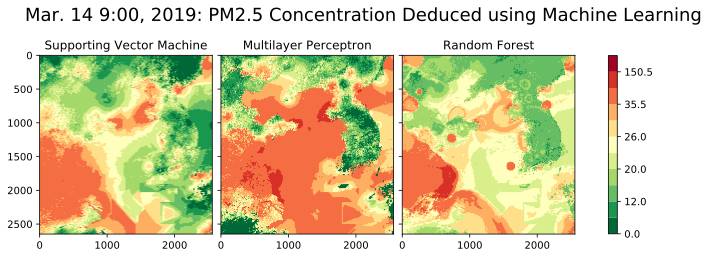

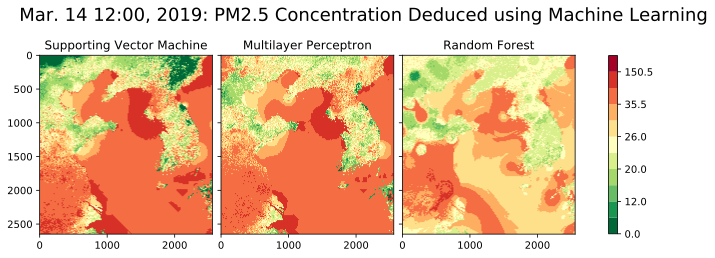

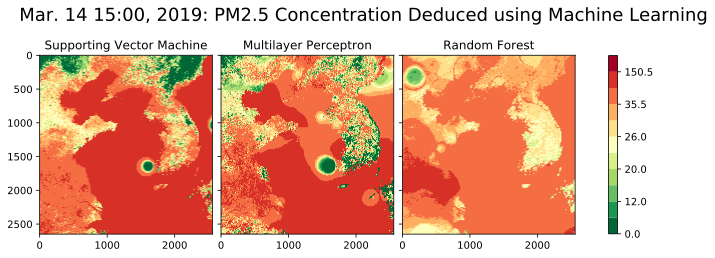

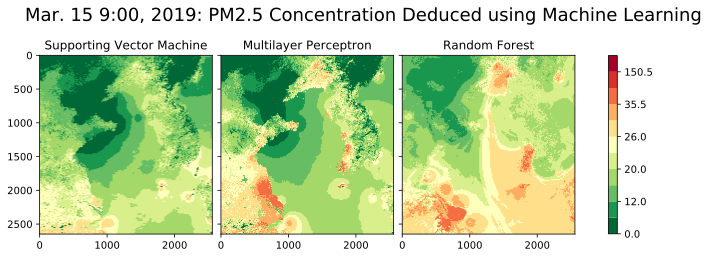

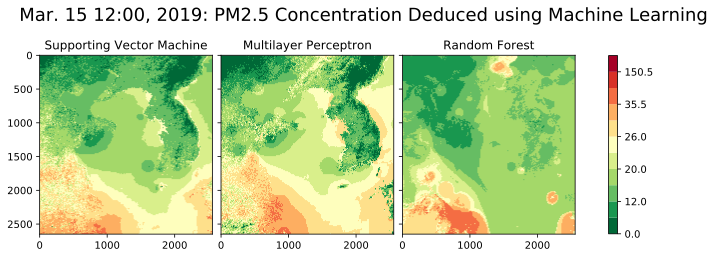

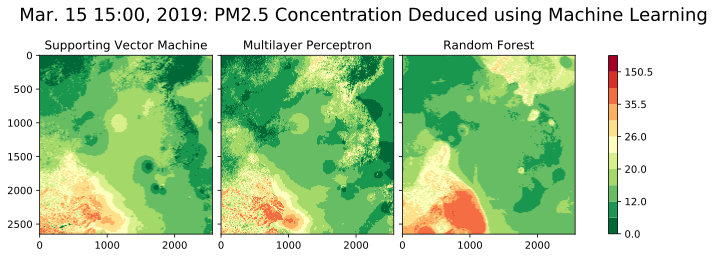

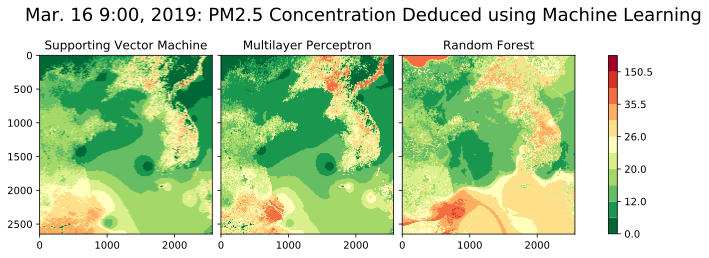

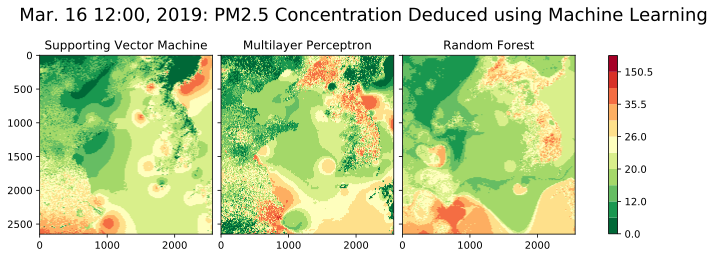

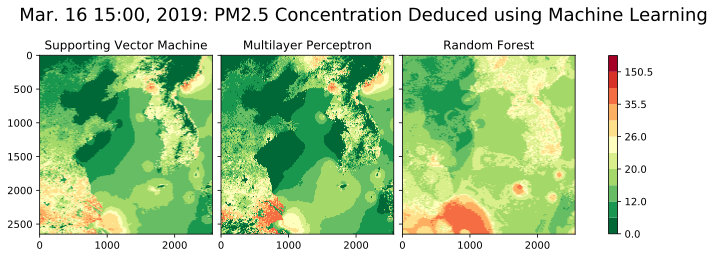

In [39]:
showDeducedPM25(14,1)
showDeducedPM25(14,4)
showDeducedPM25(14,7)
showDeducedPM25(15,1)
showDeducedPM25(15,4)
showDeducedPM25(15,7)
showDeducedPM25(16,1)
showDeducedPM25(16,4)
showDeducedPM25(16,7)

In [40]:
PM25ConcentrationDeduction(14,1)

Running PM 2.5 Deduction Program on 14-1 (date-hour).
------ SVR ------
Best parameters set found on development set:

{'C': 1000, 'epsilon': 0.5, 'gamma': 0.001, 'kernel': 'rbf'}


SVM Model Score: 0.7643608396016222
------ MLP ------
Best parameters set found on development set:

{'activation': 'relu', 'alpha': 0.0001, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'momentum': 0.9, 'solver': 'sgd'}


MLP Model Score: 0.7853277342454376
------ Random Forests ------
Best parameters set found on development set:

{'bootstrap': True, 'max_depth': 110, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


Random Forests Model Score: 0.6930383760745136
Task of Running PM 2.5 Deduction Program on 14-1 (date-hour) is finished.


Here are the deduced PM2.5 concentration maps on Mar. 14 1:00 based on Machine Learning Models


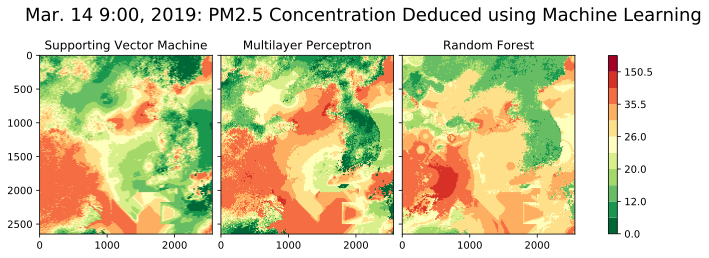

In [41]:
showDeducedPM25(14,1)